# Tasks:
1. Find a proper train test split
2. Implement a model for the segmentation task.
    - Find a proper loss function & explain the choice
    - Provide the implementation of the model architecture, dataloader & training method
    - Show that your implementation is working - one or two epochs are enough

3. Extend your pipeline to create a flip-robust segmentation
    - Add a second loss function, explain why this can be helpful and explain your choice
    - Add a flip augmentation
    - Show that your implementation is working - again one or two epochs are fine

In [1]:
# importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import os
import glob
import nibabel as nib
import tqdm
import torch.nn.functional as F
# from torch.autograd import Variable

### Loading the dataset

About the datasets: 
(source : Continual Hippocampus Segmentation with Transformers)
1. Dryad: contains 50 cases of healthy patients
2. HarP: The Harmonized Hippocampal Protocol dataset, which we refer to as HarP, contains healthy subjects and patients with Alzheimer’s disease.

I will be using the Dryad dataset for this task.

#### Data format
Given the file format provided, it appears that we have two types of files for each case in the "Dryad" dataset:
1. **s01_L_gt.nii.gz**: This file likely contains the ground truth segmentation masks for the left hippocampus of a subject from the "Dryad" dataset.

2. **s01_L.nii.gz**: This file likely contains the MRI image data (e.g., T1-weighted images) for the left hippocampus of the same subject.

The filenames indicate that they correspond to the left hemisphere of the hippocampus ("L"). Since have similar files for the right hemisphere (e.g., "s01_R_gt.nii.gz" and "s01_R.nii.gz"), we will follow a similar process for those as well.

A basic outline of our process will be as follows:
1. Load the MRI image data from files like "s01_L.nii.gz."
2. Load the corresponding ground truth segmentation masks from files like "s01_L_gt.nii.gz."
3. Preprocess the image data and masks (e.g., resizing, normalizing, and data augmentation if necessary).
4. Use these preprocessed data and masks to train and evaluate your segmentation model

In [2]:
# Define a function to load and preprocess data for a single case
def load_and_preprocess_case(data_dir, case_name):
    # Construct the file paths for image and mask
    image_file = os.path.join(data_dir, f"{case_name}.nii.gz")
    mask_file = os.path.join(data_dir, f"{case_name}_gt.nii.gz")
    
    # Load MRI image data
    img_data = nib.load(image_file).get_fdata()
    
    # Load the corresponding ground truth segmentation mask
    mask_data = nib.load(mask_file).get_fdata()
    
    return img_data, mask_data

In [3]:
# Define a function to load and preprocess the entire dataset
def load_and_preprocess_dataset(dataset_dir):
    data = []
    labels = []
    
    # Iterate through each case name
    case_names = [f"s{str(i).zfill(2)}_{hemi}" for i in range(1, 26) for hemi in ['L', 'R']]
    
    for case_name in case_names:
        img_data, mask_data = load_and_preprocess_case(dataset_dir, case_name)
        
        if img_data is not None and mask_data is not None:
            data.append(img_data)
            labels.append(mask_data)
    
    return data, labels

In [4]:
# Specify the path to the "Dryad" dataset directory
dryad_dataset_dir = 'datasets/Dryad'

# Load and preprocess the "Dryad" dataset
dryad_data, dryad_labels = load_and_preprocess_dataset(dryad_dataset_dir)

### Understanding the dataset and the MRI scans

In [5]:
# print dryad_data and dryad_labels
print("length of inputs:",len(dryad_data), " & length of labels:",len(dryad_labels))

length of inputs: 50  & length of labels: 50


/tmp/ipykernel_19811/2765177057.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


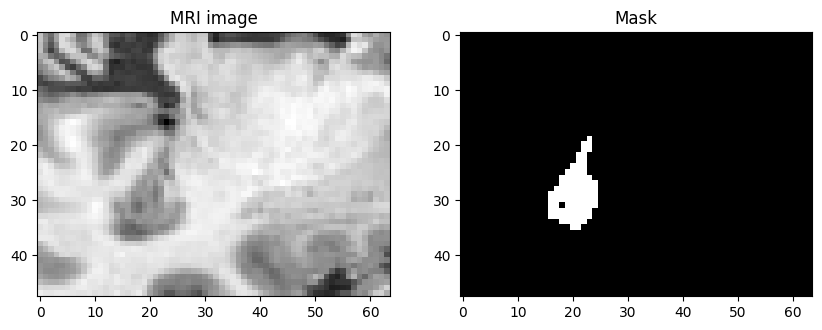

In [6]:
# visualise a slice and the corresponsing mask for a single case as an image
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title('MRI image and the corresponding mask')

plt.subplot(1,2,1)
plt.imshow(dryad_data[7][:,:,30], cmap='gray')
plt.title('MRI image')
plt.subplot(1,2,2)
plt.imshow(dryad_labels[7][:,:,30], cmap='gray')
plt.title('Mask')
plt.show()

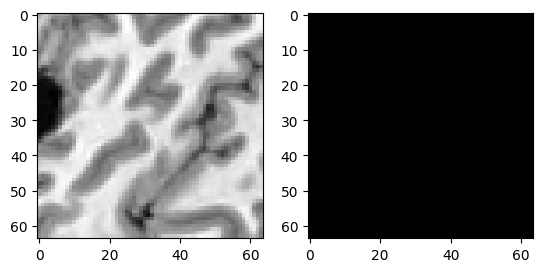

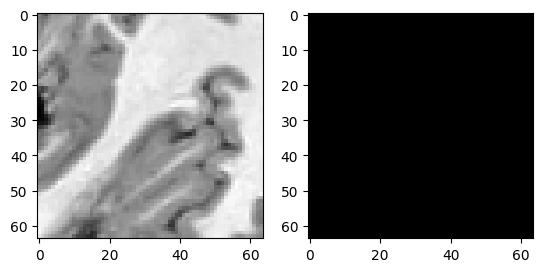

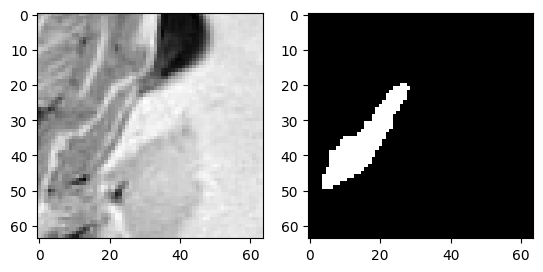

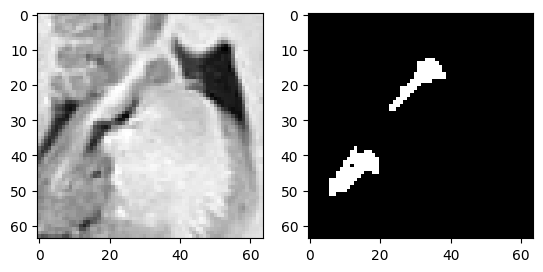

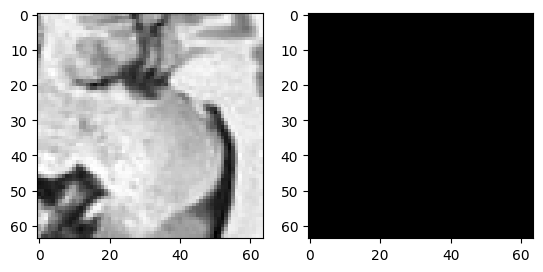

In [7]:
# Specify the range of slices you want to visualize
start_slice = 0
end_slice = 50  

# Loop through and display the slices and corresponding masks side by side

for slice_num in range(start_slice, end_slice,10):
    f2, axarr2 = plt.subplots(1,2)
    axarr2[0].imshow(dryad_data[6][slice_num, :, :], cmap='gray')
    axarr2[1].imshow(dryad_labels[6][slice_num, :, :], cmap='gray')
    plt.show()


### Implement a model for the segmentation task

In [8]:
# determining the shape of the data
print(dryad_data[0].shape)
print(dryad_labels[0].shape)

(48, 64, 64)
(48, 64, 64)


## Model Architecture: **U-Net**

<center><img title="U-Net architechture Diagram" alt="U-Net architechture Diagram" src="https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png" height=500 width=800></center>

UNet, evolved from the traditional convolutional neural network, was first designed and applied in 2015 to process biomedical images. 

<i>The reason it is able to localise and distinguish borders of abnormality and disease is by doing classification on every pixel, so the input and output share the same size.</i>

The U-Net architecture is characterized by its U-shaped structure, which consists of a contracting path followed by an expansive path. Here's an overview of its key components:

1. Contracting Path (Encoder)
2. Bottleneck
3. Expansive Path (Decoder)
4. Output Layer

(source: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
      
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels, out_classes, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(64 + 128, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [10]:
from PIL import Image  # Import PIL Image

# Define your custom dataset class for loading and preprocessing data
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'mask': self.labels[idx]}
        
        if self.transform:
            if isinstance(sample['image'], np.ndarray):
                image = Image.fromarray(sample['image'])
                mask = Image.fromarray(sample['mask'])
                
                # Apply transformations to both image and mask
                sample['image'] = self.transform(image)
                sample['mask'] = self.transform(mask)

        # Convert the transformed images back to numpy arrays if needed
        if isinstance(sample['image'], Image.Image):
            sample['image'] = np.array(sample['image'])
        if isinstance(sample['mask'], Image.Image):
            sample['mask'] = np.array(sample['mask'])
    
        sample["mask"] = torch.Tensor(np.array( [sample["mask"], 1 - sample["mask"]] ))

        return sample

# Approach
My approach has 2 significant aspects:
1. 

In [11]:
# Define the number of input channels and output classes
in_channels = 1  
out_classes = 2

In [12]:
# dice loss function

'''
The intersection is computed by element-wise multiplication (predicted_flat * target_flat) of the flattened predicted and target tensors. 
This operation calculates the number of pixels that are both predicted as positive and are actually positive in the ground truth.

The union is calculated as the sum of all positive pixels in both the predicted and target masks. It represents the total number of 
positive pixels predicted by the model and the total number of actual positive pixels in the ground truth.
'''
def dice_loss(predicted, target, smooth=1.0):
    # Flatten predicted and target tensors if they are PyTorch tensors
    predicted_flat = predicted.view(-1)
    target_flat = target.view(-1)

    intersection = torch.sum(predicted_flat * target_flat)
    union = torch.sum(predicted_flat) + torch.sum(target_flat)

    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)

    # Compute the Dice loss as 1 - Dice coefficient
    dice_loss = 1.0 - dice_coefficient

    return dice_loss

<i>Why Dice-Loss?</i>

Dice Coefficient is similar to IoU Coefficient, both being positively correlated. I used this metric since it is very intuitive in image segmentation tasks. It is a region-based loss (as shown in the table below).  It can very well handle the class imbalance
in terms of pixel count for foreground and background

<center>

| Type                           | Loss Function                    |
|--------------------------------|----------------------------------|
| Distribution-based Loss        | Binary Cross-Entropy             |
|                                | Weighted Cross-Entropy           |
|                                | Balanced Cross-Entropy           |
|                                | Focal Loss                       |
| Region-based Loss              | Dice Loss                        |
|                                | Sensitivity-Specificity Loss     |
|                                | Tversky Loss                     |
|                                | Focal Tversky Loss               |

</center>

The Dice coefficient ranges from 0 to 1, with 0 indicating no overlap between the sets and 1 indicating perfect overlap or similarity.

The smooth parameter is added to avoid division by zero errors when both intersection and union are zero. It's a small positive value that prevents instability in the loss calculation
<center><img src="https://cdn-images-1.medium.com/max/1600/0*HuENmnLgplFLg7Xv" height=300 width=550></center>


In [13]:
# defining the device variable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mixed_data=[]
mixed_labels=[]
# changing every element of the list from [48,64,64] to a list of 48 elements of size [64,64]
for i in range(len(dryad_data)):
    for j in range(dryad_data[i].shape[0]):
        mixed_data.append(dryad_data[i][j,:,:])
        mixed_labels.append(dryad_labels[i][j,:,:])

# printing the shape of the mixed_data and mixed_labels
print(len(mixed_data))
print(len(mixed_labels))

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(mixed_data, mixed_labels, test_size=0.3, random_state=42)

# Create data loaders for training and testing
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=240)
test_loader = DataLoader(test_dataset, batch_size=240)

# Define loss function
criterion = dice_loss

2400
2400


In [14]:
# training for one epoch
def train_for_one_epoch(epoch_number,model, device, train_loader, optimizer, criterion):
    # Set model to training mode
    model.train()

    # initialise total loss for this epoch
    total_loss = 0
    
    # Loop through the data in batches
    for data in train_loader:
        # Get inputs and corresponding labels
        inputs = data['image'].to(device).float()
        labels = data['mask'].to(device).float()

        # Normalising the inputs and correcting shape
        inputs = inputs.unsqueeze(1)
        inputs = inputs/torch.max(inputs)
        
        # Zero out the optimizer
        optimizer.zero_grad()
        
        # Get outputs from the model
        outputs = model(inputs)

        # normalising the outputs
        outputs = outputs/torch.max(outputs)
        
        # Get loss for the predicted outputs
        loss = criterion(outputs, labels)
        
        # Backpropagate the loss
        loss.backward()
        
        # Update the parameters
        optimizer.step()

        total_loss += loss.item()
        
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch_number}, Training Loss: {average_loss}')

In [15]:
def validation_for_one_epoch(epoch_number,model, device, test_loader, criterion):

    # Initialize the total loss
    total_loss = 0.0

    # Iterate through test data
    for test_batch in test_loader:
        # Get inputs and process them
        inputs = test_batch['image'].to(device).float()
        inputs = inputs.unsqueeze(1)
        inputs = inputs/torch.max(inputs)

        # Forward pass through the model
        with torch.no_grad():  # No need to compute gradients during inference
            output = model(inputs)

        # Batch dimension
        num_images = inputs.shape[0]

        # Initialize batch loss
        batch_loss = 0.0

        for i in range(num_images):
            input_img = inputs[i]  # Get a single image from the batch

            # Calculate the Dice loss
            predicted_mask = (output[i] > 0.5).float().squeeze().cpu().numpy()
            predicted_mask_tensor = torch.tensor(predicted_mask, dtype=torch.float32)

            dice_loss_test = dice_loss(predicted_mask_tensor, test_batch['mask'][i])
            batch_loss += dice_loss_test

        # Average Dice loss for this batch
        average_loss = batch_loss / num_images

        # Accumulate the batch loss to the total loss
        total_loss += average_loss

    # Calculate the average Dice loss across all batches
    average_loss_across_batches = total_loss / len(test_loader)
    print(f'Epoch {epoch_number}, Validation Loss: {average_loss_across_batches}')

In [16]:
# Training and validation loop in one

# Get UNet model
model = UNet(in_channels,out_classes)

# define optimiser
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2):
    
    train_for_one_epoch(epoch+1, model, device, train_loader, optimizer, criterion)

    validation_for_one_epoch(epoch+1, model, device, test_loader, criterion)
    print("----------------------------------------------------------------------------------------------------------------------")


Epoch 1, Training Loss: 0.9975898010390145
Epoch 1, Validation Loss: 0.5989072918891907
----------------------------------------------------------------------------------------------------------------------
Epoch 2, Training Loss: 0.6646210210663932
Epoch 2, Validation Loss: 0.3067960739135742
----------------------------------------------------------------------------------------------------------------------


## Extending your pipeline to create a flip-robust segmentation
3.1 Add a second loss function, explain why this can be helpful and explain your choice

3.2 Add a flip augmentation

3.3 Show that your implementation is working - again one or two epochs are fine

Adding a second loss function can be useful as:

1. **Multi-Objective Optimization**: By adding a second loss function, we can optimize multiple objectives simultaneously. For example, in a semantic segmentation task, we may want to optimize for pixel-wise accuracy as well as object-level IoU (Intersection over Union).

2. **Balancing Trade-offs**: Different loss functions emphasize different aspects of the learning task. One loss function may encourage the model to focus on minimizing errors on one aspect, while another may emphasize a different aspect.

3. **Regularization**: Each loss function contributes to the overall loss, and this can act as a form of regularization discouraging the model from fitting the training data too closely.

4. **Handling Imbalanced Data**: In classification tasks with imbalanced datasets, we can use multiple loss functions to give different weights to classes based on their importance. For example, in a medical diagnosis task, false negatives (missed cases) might be more critical than false positives (false alarms), so we could assign higher weights to the former.

5. **Domain Adaptation**: In transfer learning or domain adaptation scenarios, we may have a pre-trained model on one domain and fine-tune it for another. In such cases, we can use a second loss function tailored to the target domain to guide the adaptation process effectively.

<i>Why cross-entropy loss?</i>

Cross-entropy can then be used to calculate the difference between the two probability distributions. One of the main advantages of cross-entropy loss is that it is easy to implement and optimize. Most neural network frameworks provide built-in functions for cross-entropy loss and its gradients. Cross-entropy loss also has a smooth and convex shape, which makes it easier for gradient-based optimization methods to find the global minimum.

(source: https://www.linkedin.com/advice/0/what-advantages-disadvantages-using-cross-entropy)

In [17]:
criterion1= dice_loss
criterion2= nn.BCELoss()

In [18]:
from torchvision import transforms
# from torch.utils.data import DataLoader, Dataset

# Define data augmentation including horizontal flipping
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip horizontally
])

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(mixed_data, mixed_labels, test_size=0.3, random_state=42)

# Create data loaders for training and testing
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=240)
test_loader = DataLoader(test_dataset, batch_size=240)

# Continue training on flipped and rotated dataset
num_epochs = 2  
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

for epoch in range(num_epochs):
    # model.train()
    train_for_one_epoch(epoch+1, model, device, train_loader, optimizer, criterion)

    validation_for_one_epoch(epoch+1, model, device, test_loader, criterion)
    print("----------------------------------------------------------------------------------------------------------------------")



Epoch 1, Training Loss: 0.3611821361950466
Epoch 1, Validation Loss: 0.13832205533981323
----------------------------------------------------------------------------------------------------------------------
Epoch 2, Training Loss: 0.2196640968322754
Epoch 2, Validation Loss: 0.08738285303115845
----------------------------------------------------------------------------------------------------------------------
